In [1]:
import torch.optim as optim
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import sys

In [2]:

root = '/home/j3zeng/ECE285/ECE285_final_proj/pytorch-CycleGAN-and-pix2pix/data'
sys.path.insert(1, root)
from syn500_dataset import *
from discriminator import * 
from generator import *
from GAN import *

In [5]:
batch_size = 4
# load dataset
train_dataset = SegmentLoader('../data/Synscapes500/')
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = SegmentLoader('../data/Synscapes100/')
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


Loadding files from ../data/Synscapes500
Loaded:500
Loadding files from ../data/Synscapes100
Loaded:100


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'label image')

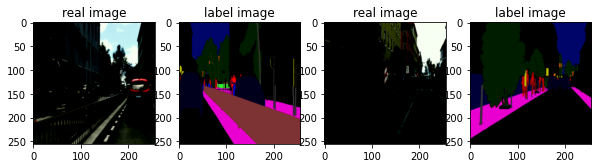

In [6]:
# show an example
fig = plt.figure(figsize=(10,3))
ax = fig.add_subplot(1,4,1)
plt.imshow(train_dataset.__getitem__(0)['B'].permute(1,2,0))
plt.title('real image')
ax = fig.add_subplot(1,4,2)
plt.imshow(train_dataset.__getitem__(0)['A'].permute(1,2,0))
plt.title('label image')
ax = fig.add_subplot(1,4,3)
plt.imshow(test_dataset.__getitem__(0)['B'].permute(1,2,0))
plt.title('real image')
ax = fig.add_subplot(1,4,4)
plt.imshow(test_dataset.__getitem__(0)['A'].permute(1,2,0))
plt.title('label image')

In [7]:
# default setting
lr = 1e-3
beta1 = 0.5
lambda_L1 = 100

In [13]:
model = torch.load('/home/j3zeng/ECE285/ECE285_final_proj/pytorch-CycleGAN-and-pix2pix/netG.pt')

ModuleNotFoundError: No module named 'models'

In [8]:
model = nn.Sequential(
        nn.Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn. BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.LeakyReLU(negative_slope=0.2, inplace=True),
        nn.Conv2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(512, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.Dropout(p=0.5, inplace=False),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(1024, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(512, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(256, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False),
        nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        nn.ReLU(inplace=True),
        nn.ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        )

In [9]:
# initialize
G_net =model

D_net = Discriminator(inputc = 6)

criterionGAN = GANLoss().cuda()
L1Loss = nn.L1Loss().cuda()
optimizer_G = optim.Adam(G_net.parameters(), lr=lr, betas = (beta1, 0.999))
optimizer_D = optim.Adam(D_net.parameters(), lr=lr, betas = (beta1, 0.999))

In [10]:
# initialize weight
def init_weight(m):
    if isinstance(m, nn.Conv2d):
        nn.init.normal_(m.weight, mean=0.0, std=0.02)
    else:
        pass
G_net.apply(init_weight)
D_net.apply(init_weight)

Discriminator(
  (conv1): Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (bn4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(512, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv6): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
  (relu): LeakyReLU(negative_slope=0.2, inplace=True)
  (sigmoid): S

In [11]:
# parallel
G_net = torch.nn.DataParallel(G_net, device_ids=range(len('0'))).cuda()
D_net = torch.nn.DataParallel(D_net, device_ids=range(len('0'))).cuda()

In [12]:
for epoch in range(10):
    # visualize
    test_sample = next(iter(test_loader))
    test_out, test_in = test_sample['B'], test_sample['A']
    test_in = test_in.cuda()
    test_pred = G_net(test_in)
    fig = plt.figure(figsize=(10,3))
    ax = fig.add_subplot(1,3,1)
    plt.imshow(test_out[0,:,:,:].permute(1,2,0))
    plt.title('real')
    ax = fig.add_subplot(1,3,2)
    plt.imshow(test_in[0,:,:,:].cpu().permute(1,2,0))
    plt.title('input')
    ax = fig.add_subplot(1,3,3)
    plt.imshow(test_pred[0,:,:,:].cpu().permute(1,2,0))
    plt.title('pred')
    fig.tight_layout()
    plt.show()
    
    
    for i, real_sample in enumerate(train_loader):
        # one iteration
        real_output = real_sample['B']
        real_input = real_sample['A']
        # forward Generator
        real_output = real_output.cuda()
        real_input = real_input.cuda()
        fake_out = G_net(real_input)
        # calcuate loss for Discriminator
        pred_fake = D_net(torch.cat((real_input, fake_out),1))
        loss_fake = criterionGAN(pred_fake, real=False)

        pred_real = D_net(torch.cat((real_input, real_output),1))
        loss_real = criterionGAN(pred_real, real=True)
        loss_D = 1/2*(loss_fake + loss_real)
        # set Discriminator's gradient to true and set Generator's gradient to false
        for param in G_net.parameters():
            param.requires_grad = False
        for param in D_net.parameters():
            param.requires_grad = True
        # update Discriminator
        optimizer_D.zero_grad()
        optimizer_D.step()

        # caculate loss for Generator
        pred_fake = D_net(torch.cat((real_input, fake_out),1))
        loss_fake = criterionGAN(pred_fake, real=True)
        loss_L1 = L1Loss(fake_out, real_output) * lambda_L1
        loss_G = loss_fake + loss_L1
        # set Generator's gradient to true and set Discriminator's gradient to false
        for param in D_net.parameters():
            param.requires_grad = False
        for param in G_net.parameters():
            param.requires_grad = True
        # update Generator
        optimizer_G.zero_grad()
        optimizer_G.step()
        if i % 50 == 0:
            print(f'epoch: {epoch}/{i} -- loss_D: {loss_D}, loss_G: {loss_G}')
        

RuntimeError: Given transposed=1, weight of size [1024, 512, 4, 4], expected input[4, 512, 2, 2] to have 1024 channels, but got 512 channels instead

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
real_out = plt.imshow(train_dataset.__getitem__(0)[0].permute(1,2,0))

In [ ]:
real_in = plt.imshow(train_dataset.__getitem__(0)[1].permute(1,2,0))